### Домашнее задание к 5 вебинару ML in business

1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)
2. Отобрать лучшую модель по метрикам (кстати, какая по вашему мнению здесь наиболее подходящая DS-метрика)
3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 
4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

In [1]:
import pandas as pd
import numpy as np
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
#from sklearn.feature_extraction.text import TfidfVectorizer
import itertools

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
df = pd.read_csv("churn_data.csv")
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Есть как категориальные, так и вещественные признаки. Поле CustomerId нужно будет удалить. 

Посмотрим на распределение классов:

In [3]:
df['Exited'].value_counts()

0    7963
1    2037
Name: Exited, dtype: int64

Не самое плохое распределение (1 к 4)

Давайте построим модель. Сразу же будем работать с использованием sklearn pipeline

In [4]:
#разделим данные на train/test
X_train, X_test, y_train, y_test = train_test_split(df, df['Exited'], random_state=0)

- Категориальные признаки закодируем с помощью OneHotEncoding
- Вещественные оставим пока как есть

In [5]:
#соберем наш простой pipeline, но нам понадобится написать класс для выбора нужного поля
class FeatureSelector(BaseEstimator, TransformerMixin):
    def __init__(self, column):
        self.column = column

    def fit(self, X, y=None):
        return self

    def transform(self, X, y=None):
        return X[self.column]
    
class NumberSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    Use on numeric columns in the data
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[[self.key]]
    
class OHEEncoder(BaseEstimator, TransformerMixin):
    def __init__(self, key):
        self.key = key
        self.columns = []

    def fit(self, X, y=None):
        self.columns = [col for col in pd.get_dummies(X, prefix=self.key).columns]
        return self

    def transform(self, X):
        X = pd.get_dummies(X, prefix=self.key)
        test_columns = [col for col in X.columns]
        for col_ in self.columns:
            if col_ not in test_columns:
                X[col_] = 0
        return X[self.columns]

In [6]:
df.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1


Зададим списки признаков

In [7]:
categorical_columns = ['Geography', 'Gender', 'Tenure', 'HasCrCard', 'IsActiveMember', 'NumOfProducts']
continuous_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.pipeline import FeatureUnion

# gender = Pipeline([
#                 ('selector', FeatureSelector(column='Gender')),
#                 ('ohe', OHEEncoder(key='Gender'))
#             ])
# gender.fit(X_train)
# gender.transform(X_test).head(3)

Теперь нам нужно под каждый признак создать трансформер и объединить их в список (сделаем это в цикле, чтобы не мучиться)

In [9]:
final_transformers = list()

for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', FeatureSelector(column=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    final_transformers.append((cat_col, cat_transformer))
    
for cont_col in continuous_columns:
    cont_transformer = Pipeline([
                ('selector', NumberSelector(key=cont_col))
            ])
    final_transformers.append((cont_col, cont_transformer))

Объединим все это в единый пайплайн

In [10]:
feats = FeatureUnion(final_transformers)

feature_processing = Pipeline([('feats', feats)])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [11]:
from sklearn.ensemble import RandomForestClassifier

pipeline = Pipeline([
    ('features',feats),
    ('classifier', RandomForestClassifier(random_state = 42)),
])

Таблица для сохранения результатов моделей

In [12]:
#таблица ответов
compare_classifiers_metrics = pd.DataFrame(columns=['Classifier',
                                                    'Precision',
                                                    'Recall',
                                                    'Fscore',
                                                    'PR_auc_score',
                                                    'ROC_auc_score'
                                                   ])
compare_classifiers_metrics

,Classifier,Precision,Recall,Fscore,PR_auc_score,ROC_auc_score


Обучим модель

In [13]:
#обучим наш пайплайн
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [14]:
#наши прогнозы для тестовой выборки
preds = pipeline.predict_proba(X_test)[:, 1]
preds[:10]

array([0.34, 0.26, 0.2 , 0.02, 0.01, 0.75, 0.06, 0.11, 0.19, 0.68])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [15]:
from sklearn.metrics import f1_score, roc_auc_score, precision_score, classification_report, precision_recall_curve, confusion_matrix

In [16]:
precision, recall, thresholds = precision_recall_curve(y_test, preds)

fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

Best Threshold=0.370000, F-Score=0.654, Precision=0.647, Recall=0.662


In [17]:
from sklearn.metrics import auc

In [18]:
p_r_auc = auc(recall, precision)
roc_auc_scr = roc_auc_score(y_true=y_test, y_score=preds)

In [19]:
# for model in model_list:

compare_classifiers_metrics = compare_classifiers_metrics.append({
                                                                'Classifier': RandomForestClassifier.__name__,
                                                                'Precision': precision[ix],
                                                                'Recall': recall[ix],
                                                                'Fscore': fscore[ix],
                                                                'PR_auc_score': p_r_auc,
                                                                'ROC_auc_score': roc_auc_scr
                                                                }, ignore_index=True)

#### Вопрос 1: объясните своими словами смысл метрик Precison, Recall *
1. Какова их взаимосвязь и как с ними связан порог вероятности? 
2. Можно ли подобрать порог так, что recall будет равен 1? Что при этом будет с precision
3. Аналогичный вопрос про precision

Ваш ответ здесь:

**Precision** - это насколько точно предсказали целевую переменную. Т.е. какая доля из предсказанных Positive действительно таковой является. Например, при предсказании оттока precision показывает, какая доля из тех, кому предсказали уход, действительно ушла (если с ними не проводились мероприятия по удержанию, основанные на прогнозах модели). И, соответсвенно, ( 1.0 минус precision) - это доля тех, кого по предсказаниям модели определили в отток, при том что они таковым не являются.

**Recall** - это насколько полно предсказали целевую переменную. Максимальное значение Recall - это когда модель "выловила"  все имеющиеся в выборке P true, верно предсказала максимальное их количество. При этом этой метрике неважно, сколько верных и неверных предсказаний нецелевой переменной (N) дала модель. Т.е. сама по себе recall максимизируется примитивным предсказанием 1 по всей выборке.

Так как модели выдают предсказания вероятности от 0.0 до 1.0, то порог определяет, как в итоге будет классифицироваться та или иная вероятность. При пороге 0.4 вероятность 0.45 будет отнесена к 1 (P, positive), а при пороге 0.5 - уже к  0(N, negative). С увеличением порога увеличивается количество negative(N) за счет positive(P), а значит растет TN и FN , а TP и FP уменьшается.

1. Взаимосвязь Precision и Recall нелинейная.В зависимости от качества модели при росте Precision Recall может как расти, так и уменьшаться.


2. **Recall = TP/(TP+FN)**. С увеличением порога FN растет и следовательно Recall уменьшается. Т.е. **при пороге близком к 0 - Recall ,близится к 1.0 (precision при этом падает)**, и наоборот, порог 1 обеспечивает recall = 0 или близкую к 0. Скорость этого уменьшения также зависит от качества модели (**в идеальной модели со 100% точностью предсказаний recall = 1 независимо от значения порога**).


3. **Precision = TP/(TP + FP)**, то есть при изменении порога precision в теории может как расти, так и снижаться (в зависимости от качества модели). При этом, если модель нерандомная, а с ростом значения predict_proba действительно растет доля верно предсказанных - то при увеличении порога precision будет расти за счет того, что будут отбрасываться те пресказания, в которых модель менее уверена. То есть, тогда **при увеличении порога ближе к 1.0 precision также станет 1 (т.е. мы отбросим все предсказания кроме тех, в которых максимально уверены). Recall при этом скорее всего упадет, степень падения зависит от качества модели.**



Отрисуем матрицу ошибок

In [20]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1817  174]
 [ 184  325]]


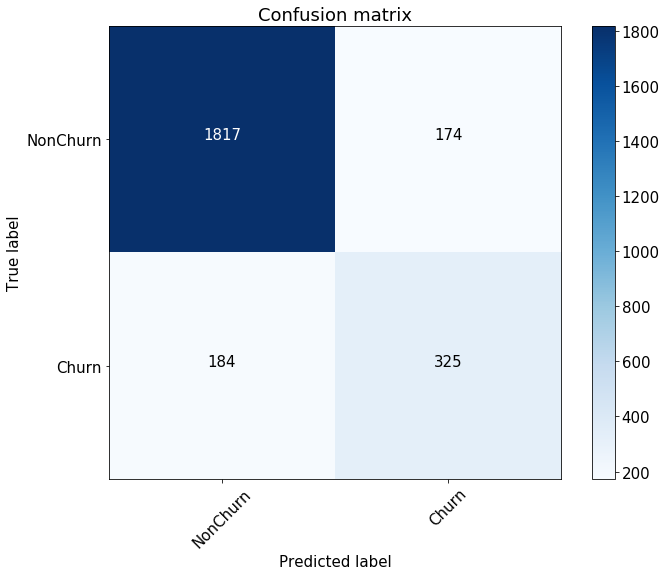

In [21]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Можно заметить, что мы очень сильно ошибаемся в сторону False Negatives, т.е у нас много тех, кто ушел в отток на самом деле, но при выбранном нами пороге в 0.38 мы не считаем их таковыми. 

<b>Вопрос 2: предположим, что на удержание одного пользователя у нас уйдет 1 доллар. При этом средняя ожидаемая прибыль с каждого TP (true positive) - 2 доллара. Оцените качество модели выше с учетом этих данных и ответьте на вопрос, является ли она потенциально экономически целесообразной?</b>

Ваш ответ здесь: 

In [22]:
EXPENSE = 1 #затраты на удержание
PROFIT = 2 # прибыль от удержания

profit_model = PROFIT * cnf_matrix[1,1]
expenses_model = EXPENSE * sum(cnf_matrix[:,1])
income = profit_model - expenses_model

print ( 'Profit = ', profit_model, '\nExpences = ', expenses_model, '\nIncome = ', income )

print('Model is potentially ' + 'not ' * (income <= 0) + 'economically feasible.') 

Profit =  650 
Expences =  499 
Income =  151
Model is potentially economically feasible.


C:\Users\LMAXL\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # Remove the CWD from sys.path while we load stuff.


*1. Для нашего пайплайна (Case1) поэкспериментировать с разными моделями: 1 - бустинг, 2 - логистическая регрессия (не забудьте здесь добавить в cont_transformer стандартизацию - нормирование вещественных признаков)*

In [23]:
from catboost import CatBoostClassifier

In [24]:
pipeline_cat = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(random_state = 42, silent = True)),
])

In [ ]:
CatBoostClassifier

Обучим модель

In [25]:
#обучим наш пайплайн
pipeline_cat.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

In [26]:
#наши прогнозы для тестовой выборки
preds_cat = pipeline_cat.predict_proba(X_test)[:, 1]
preds_cat[:10]

array([0.42284746, 0.26074613, 0.11419026, 0.04857906, 0.01496343,
       0.84520951, 0.02188176, 0.1159429 , 0.15579702, 0.89110494])

Также нам нужно от вероятностей перейти к меткам классов. Для этого нужно подобрать порог, после которого мы считаем, что объект можно отнести к классу 1 (если вероятность больше порога - размечаем объект как класс 1, если нет - класс 0)

In [27]:
precision_cat, recall_cat, thresholds_cat = precision_recall_curve(y_test, preds_cat)

fscore_cat = (2 * precision_cat * recall_cat) / (precision_cat + recall_cat)
# locate the index of the largest f score
ix_cat = np.argmax(fscore_cat)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_cat[ix_cat], 
                                                                        fscore_cat[ix_cat],
                                                                        precision_cat[ix_cat],
                                                                        recall_cat[ix_cat]))

Best Threshold=0.337461, F-Score=0.646, Precision=0.628, Recall=0.666


Отрисуем матрицу ошибок

Confusion matrix, without normalization
[[1790  201]
 [ 171  338]]


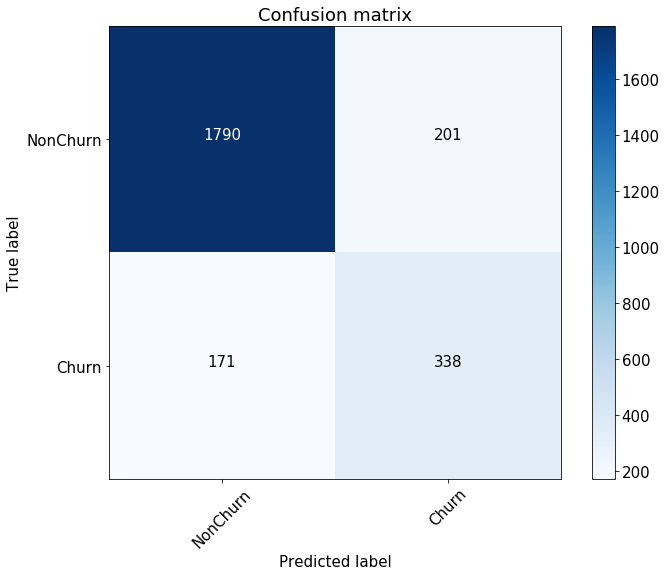

In [28]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_cat = confusion_matrix(y_test, preds_cat>thresholds_cat[ix_cat])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_cat, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [29]:
p_r_auc_cat = auc(recall_cat, precision_cat)
roc_auc_scr_cat = roc_auc_score(y_true=y_test, y_score=preds_cat)

In [30]:
# for model in model_list:

compare_classifiers_metrics = compare_classifiers_metrics.append({
                                                                'Classifier': CatBoostClassifier.__name__,
                                                                'Precision': precision_cat[ix_cat],
                                                                'Recall': recall_cat[ix_cat],
                                                                'Fscore': fscore_cat[ix_cat],
                                                                'PR_auc_score': p_r_auc_cat,
                                                                'ROC_auc_score': roc_auc_scr_cat
                                                                }, ignore_index=True)

Для использования лог.регрессии добавляем в cont_transformer нормирование вещественных признаков

In [31]:
df[continuous_columns].describe()

,CreditScore,Age,Balance,EstimatedSalary
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,76485.889288,100090.239881
std,96.653299,10.487806,62397.405202,57510.492818
min,350.000000,18.000000,0.000000,11.580000
25%,584.000000,32.000000,0.000000,51002.110000
50%,652.000000,37.000000,97198.540000,100193.915000
75%,718.000000,44.000000,127644.240000,149388.247500
max,850.000000,92.000000,250898.090000,199992.480000


In [32]:
# Так как значения у всех числовых колонок положительные, то для нормирования используем minmax scaler 

from sklearn.preprocessing import MinMaxScaler


In [33]:
class ColumnSelector(BaseEstimator, TransformerMixin):
    """
    Transformer to select a single column from the data frame to perform additional transformations on
    """
    def __init__(self, key):
        self.key = key

    def fit(self, X, y=None):
        return self

    def transform(self, X):
        return X[self.key]

In [34]:

continuos_transformers = []
cat_transformers = []


for cont_col in continuous_columns:
    transfomer =  Pipeline([
                ('selector', NumberSelector(key=cont_col)),
                ('standard', MinMaxScaler())
            ])
    continuos_transformers.append((cont_col, transfomer))
    
for cat_col in categorical_columns:
    cat_transformer = Pipeline([
                ('selector', ColumnSelector(key=cat_col)),
                ('ohe', OHEEncoder(key=cat_col))
            ])
    cat_transformers.append((cat_col, cat_transformer))

Теперь объединим все наши трансформеры с помощью FeatureUnion

In [35]:
from sklearn.pipeline import FeatureUnion

feats_lr = FeatureUnion(continuos_transformers+cat_transformers)
feature_processing = Pipeline([('feats', feats_lr)])

feature_processing.fit_transform(X_train)

array([[0.458     , 0.31343284, 0.49429299, ..., 0.        , 1.        ,
        0.        ],
       [0.8       , 0.20895522, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.758     , 0.23880597, 0.22358532, ..., 1.        , 0.        ,
        0.        ],
       ...,
       [0.776     , 0.25373134, 0.67652041, ..., 1.        , 0.        ,
        0.        ],
       [0.48      , 0.29850746, 0.        , ..., 1.        , 0.        ,
        0.        ],
       [0.546     , 0.44776119, 0.45336397, ..., 0.        , 0.        ,
        0.        ]])

Теперь у нас есть пайплайн, который готовит признаки для моделирования.

Добавим модель

In [36]:

pipeline_lr = Pipeline([
    ('features',feats_lr),
    ('classifier', LogisticRegression(random_state = 42)),
])

In [37]:
#обучим наш пайплайн
pipeline_lr.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('CreditScore',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  NumberSelector(key='CreditScore')),
                                                                 ('standard',
                                                                  MinMaxScaler(copy=True,
                                                                               feature_range=(0,
                                                                                              1)))],
                                                          verbose=False)),
                                                ('Age',
                                                 Pipeline(memory=None,
                       

In [38]:
#наши прогнозы для тестовой выборки
preds_lr = pipeline_lr.predict_proba(X_test)[:, 1]
preds_lr[:10]

array([0.29564582, 0.42002779, 0.19167172, 0.15834829, 0.05215592,
       0.26315949, 0.0260479 , 0.02378594, 0.47458671, 0.41214344])

In [39]:
precision_lr, recall_lr, thresholds_lr = precision_recall_curve(y_test, preds_lr)

fscore_lr = (2 * precision_lr * recall_lr) / (precision_lr + recall_lr)
# locate the index of the largest f score
ix_lr = np.argmax(fscore_lr)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds_lr[ix_lr], 
                                                                        fscore_lr[ix_lr],
                                                                        precision_lr[ix_lr],
                                                                        recall_lr[ix_lr]))

Best Threshold=0.306319, F-Score=0.585, Precision=0.526, Recall=0.660


In [40]:
p_r_auc_lr = auc(recall_lr, precision_lr)
roc_auc_scr_lr = roc_auc_score(y_true=y_test, y_score=preds_lr)

In [41]:
# for model in model_list:

compare_classifiers_metrics = compare_classifiers_metrics.append({
                                                                'Classifier': LogisticRegression.__name__,
                                                                'Precision': precision_lr[ix_lr],
                                                                'Recall': recall_lr[ix_lr],
                                                                'Fscore': fscore_lr[ix_lr],
                                                                'PR_auc_score': p_r_auc_lr,
                                                                'ROC_auc_score': roc_auc_scr_lr
                                                                }, ignore_index=True)

Confusion matrix, without normalization
[[1817  174]
 [ 184  325]]


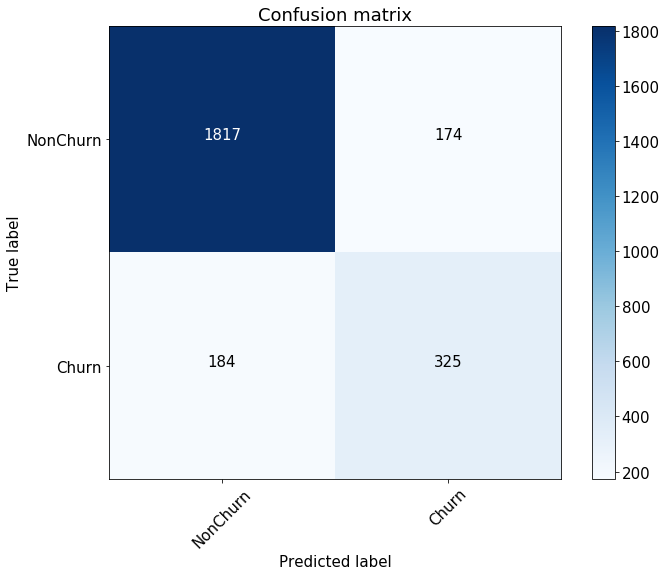

In [42]:
#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix_lr = confusion_matrix(y_test, preds_lr>thresholds_lr[ix_lr])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Сравним и отберем лучшую модель по метрикам (наиболее подходящая DS-метрика PR AUC, т.к. целевая переменная несбалансирована.

In [43]:
compare_classifiers_metrics.sort_values('PR_auc_score', ascending=False)

,Classifier,Precision,Recall,Fscore,PR_auc_score,ROC_auc_score
1,CatBoostClassifier,0.627778,0.666012,0.646330,0.721419,0.875811
0,RandomForestClassifier,0.646833,0.662083,0.654369,0.695589,0.863852
2,LogisticRegression,0.525822,0.660118,0.585366,0.620902,0.837067


Наилучшие результаты по всем метрикам у CatBoostClassifier

3. Для отобранной модели (на отложенной выборке) сделать оценку экономической эффективности при тех же вводных, как в вопросе 2 (1 доллар на привлечение, 2 доллара - с каждого правильно классифицированного (True Positive) удержанного). (подсказка) нужно посчитать FP/TP/FN/TN для выбранного оптимального порога вероятности и посчитать выручку и траты. 

In [45]:
# EXPENSE = затраты на удержание
# PROFIT = прибыль от удержания

profit_model = PROFIT * cnf_matrix_cat[1,1]
expenses_model = EXPENSE * sum(cnf_matrix_cat[:,1])
income = profit_model - expenses_model

print ( 'Profit = ', profit_model, '\nExpences = ', expenses_model, '\nIncome = ', income )

print('Model is potentially ' + 'not ' * (income <= 0) + 'economically feasible.') 

Profit =  676 
Expences =  539 
Income =  137
Model is potentially economically feasible.


C:\Users\LMAXL\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # Remove the CWD from sys.path while we load stuff.


4. (опционально) Провести подбор гиперпараметров лучшей модели по итогам 2-3
5. (опционально) Еще раз провести оценку экономической эффективности

### Пример с перебором параметров с помощью GridSearch

In [50]:
pipeline_cat[1].get_all_params()

{'nan_mode': 'Min',
 'eval_metric': 'Logloss',
 'iterations': 1000,
 'sampling_frequency': 'PerTree',
 'leaf_estimation_method': 'Newton',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'model_shrink_mode': 'Constant',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'rsm': 1,
 'boost_from_average': False,
 'model_size_reg': 0.5,
 'pool_metainfo_options': {'tags': {}},
 'subsample': 0.800000011920929,
 'use_best_model': False,
 'class_names': [0, 1],
 'random_seed': 42,
 'depth': 6,
 'posterior_sampling': False,
 'border_count': 254,
 'classes_count': 0,
 'auto_class_weights': 'None',
 'sparse_features_conflict_fraction': 0,
 'leaf_estimation_backtracking': 'AnyImprovement',
 'best_model_min_trees': 1,
 'model_shrink_rate': 0,
 'min_data_in_leaf': 1,
 'loss_function': 'Logloss',
 'learning_rate': 0.024354999884963036,
 'score_function': 'Cosine',
 'task_type': 'CPU'

Сетка с параметрами

In [51]:
from sklearn.model_selection import GridSearchCV

# params={'classifier__max_features':[0.3, 0.5, 0.7],
#         'classifier__min_samples_leaf':[1, 2, 3],
#         'classifier__max_depth':[None]
#         }

In [63]:
params={'classifier__iterations':[500, 1000, 5000],
        'classifier__depth':[3, 6, 9],
        'classifier__learning_rate':[0.024354999884963036, 0.05, 0.1, 0.5],        
        'classifier__max_leaves':[32, 64, 128]
        }

# 'iterations': 1000,
# 'depth': 6,
# 'learning_rate': 0.024354999884963036, 
#     'max_leaves': 64



Запускаем перебор

In [64]:
grid = GridSearchCV(pipeline_cat,
                    param_grid=params,
                    cv=6,
                    refit=False)

search = grid.fit(X_train, y_train)
search.best_params_

C:\Users\LMAXL\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:536: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
_catboost.CatBoostError: C:/Program Files (x86)/Go Agent/pipelines/BuildMaster/catboost.git/catboost/private/libs/options/catboost_options.cpp:893: max_leaves option works only with lossguide tree growing

  FitFailedWarning)


{'classifier__depth': 6,
 'classifier__iterations': 500,
 'classifier__learning_rate': 0.024354999884963036,
 'classifier__max_leaves': 64}

Обучаем модель уже сновыми параметрами

In [68]:
pipeline = Pipeline([
    ('features',feats),
    ('classifier', CatBoostClassifier(depth=6, iterations=500, 
                                          learning_rate=0.024354999884963036,
                                      max_leaves=64,random_state=42, silent = True)),
])
pipeline.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('Geography',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Geography')),
                                                                 ('ohe',
                                                                  OHEEncoder(key='Geography'))],
                                                          verbose=False)),
                                                ('Gender',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FeatureSelector(column='Gender')),
                                     

Best Threshold=0.357093, F-Score=0.653, Precision=0.652, Recall=0.654
Confusion matrix, without normalization
[[1813  178]
 [ 177  332]]


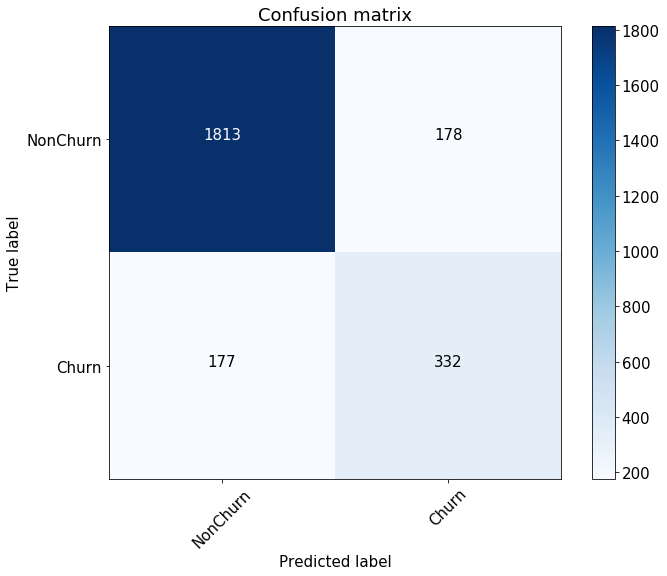

In [69]:
preds = pipeline.predict_proba(X_test)[:, 1]
precision, recall, thresholds = precision_recall_curve(y_test, preds)
fscore = (2 * precision * recall) / (precision + recall)
# locate the index of the largest f score
ix = np.argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f, Precision=%.3f, Recall=%.3f' % (thresholds[ix], 
                                                                        fscore[ix],
                                                                        precision[ix],
                                                                        recall[ix]))

#мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

cnf_matrix = confusion_matrix(y_test, preds>thresholds[ix])
plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix, classes=['NonChurn', 'Churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

In [71]:
p_r_auc = auc(recall, precision)
roc_auc_scr = roc_auc_score(y_true=y_test, y_score=preds)
print ('AUC PR = ', p_r_auc, 'AUC ROC = ', roc_auc_scr )

AUC PR =  0.7279138445982684 AUC ROC =  0.879588797920702


Метрики немного добавили в 3м знаке.

In [72]:
# EXPENSE затраты на удержание
# PROFIT прибыль от удержания

profit_model = PROFIT * cnf_matrix[1,1]
expenses_model = EXPENSE * sum(cnf_matrix[:,1])
income = profit_model - expenses_model

print ( 'Profit = ', profit_model, '\nExpences = ', expenses_model, '\nIncome = ', income )

print('Model is potentially ' + 'not ' * (income <= 0) + 'economically feasible.') 

Profit =  664 
Expences =  510 
Income =  154
Model is potentially economically feasible.


C:\Users\LMAXL\anaconda3\lib\site-packages\ipykernel_launcher.py:10: DeprecationWarning: In future, it will be an error for 'np.bool_' scalars to be interpreted as an index
  # Remove the CWD from sys.path while we load stuff.


Итоговая модель потенциально наиболее выгодная